# Interaction importance on the Wisconsin Breast Cancer Dataset

In this example, a polynomial SVM is trained on the Wisconsin breast canser dataset [0] and the interactions of the resulting model is retrieved using ExplainPolySVM. Hyperparameters are tuned using 5-fold crossvalidation and a test performance is evaluated on a held-out, randomly selected test set.

To compare importance of the interactions, we normalize each feature to zero mean and unit variance.

[0] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 

In [1]:
import numpy as np

from explainpolysvm import expsvm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Seed for reproducability
rng = np.random.default_rng(1011)


In [2]:
# Set to True to store figures in ./images
save_figs = True

In [3]:
data = load_breast_cancer()

In [4]:
X = data['data']
y = data['target']
f_names = data['feature_names']
y_names = data['target_names']

# In dataset, targets y are in {0,1}. We replace 0 with -1 to conform with standard SVM nomenclature
y[y==0] = -1

# Create dictionary mapping index of features to their names. Used for plotting.
f_name_dict = {str(num):name for num, name in enumerate(f_names)}
f_name_dict['constant'] = 'constant'  # Add constant to feature name dictionary

In [5]:
# Hyperparameters to sweep
Cs = np.arange(0.1, 5.2, 0.2)
ds = [1, 2, 3, 4]
rs = np.arange(0, 10.5, 0.5)

Split dataset into training, validation and test sets.

Then, normalize all three sets by the mean and standard deviation of the training set (standardization).

Finally, run hyperparameter sweep.

In [6]:
gamma = 'scale'
kernel = 'poly'

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Set up 5-fold crossvalidation
k = 5
n_train = X_train.shape[0]
fold_labels = rng.permutation(np.repeat(np.arange(k), np.ceil(n_train/k)))[0:n_train]

# Results array from hyperparameter sweep, columns are [C, d, r, acc]
res = np.zeros((len(Cs)*len(ds)*len(rs),4))

ind = 0
for C in Cs:
    for d in ds:
        for r in rs:
            n_correct = 0
            for fold in np.arange(k):
                # Get fold training and validation sets
                X_train_fold = X_train[fold_labels!=fold]
                y_train_fold = y_train[fold_labels!=fold]
                X_val_fold = X_train[fold_labels==fold]
                y_val_fold = y_train[fold_labels==fold]
                
                # Standardize data
                scaler = StandardScaler()
                scaler.fit(X_train_fold)
                X_train_fold = scaler.transform(X_train_fold)
                X_val_fold = scaler.transform(X_val_fold)
                
                # Train SVC
                model = SVC(C=C, kernel=kernel, degree=d, gamma=gamma, coef0=r)
                model.fit(X_train_fold, y_train_fold)

                # Predict validation set and couont number of correct predictions
                y_pred_fold = model.predict(X_val_fold)
                n_correct_fold = np.sum(y_val_fold==y_pred_fold)
                
                # Collect results
                n_correct += n_correct_fold
            
            # Collect used hyperparameters and go to next iteration
            res[ind,:] = np.array([C, d, r, n_correct/n_train])
            ind += 1
            

# Extract best hyperparameters
ind_best = np.argmax(res[:,3])
C_best, d_best, r_best, acc_best = res[ind_best, :]
d_best = int(d_best)  # Convert back to integer
print('Best hyperparameters found: C={:.1f}, d={}, r={}. 5-fold val. accuracy {:.3f}'.format(C_best, d_best, r_best, acc_best))

Best hyperparameters found: C=0.3, d=2, r=5.5. 5-fold val. accuracy 0.976


Retrain model with the combined training and validation sets, using the best hyperparameter combination, and evaluate on test set.

In [7]:
# Standardize training and test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Fit SVM
model = SVC(C=C_best, kernel=kernel, degree=d_best, gamma=gamma, coef0=r_best)
model.fit(X_train_scale, y_train)

# Test accuracy
test_acc = model.score(X_test_scale, y_test)
print('Test accuracy: {:.5f}'.format(test_acc))

Test accuracy: 0.98246


# Convert SVM with ExpSVM

In [8]:
sv = model.support_vectors_
dual_coef = np.squeeze(model.dual_coef_)
intercept = model.intercept_[0]
kernel_gamma = model._gamma

es = expsvm.ExPSVM(sv=sv, dual_coef=dual_coef, intercept=intercept,
                kernel_d=d_best, kernel_r=r_best, kernel_gamma=kernel_gamma)
es.transform_svm()

In [9]:
# Verify that performance has not changed (significantly) in the conversion.
y_pred = np.sign(es.decision_function(x=X_test_scale))
expsvm_acc = np.sum(y_pred==y_test)/y_test.size
print('Test accuracy with ExpSVM: {:.5f}. Difference between SVC and ExpSVM (SVC_acc-ExpSVM_acc) on test accuracy: {:.2e}'.format(expsvm_acc, test_acc-expsvm_acc))

Test accuracy with ExpSVM: 0.98246. Difference between SVC and ExpSVM (SVC_acc-ExpSVM_acc) on test accuracy: 0.00e+00


# Interaction importance

In [10]:
def format_interaction_names(feature_name_dict, feature_names_raw):
    """Format interaction names according to feature_name_dict.
    """
    interaction_names = []
    for ind, feat_name in enumerate(feature_names_raw):
        interaction_name = ')*('.join([feature_name_dict[f] for f in feat_name.split(',')])
        
        if '*' not in interaction_name:
            interaction_name = interaction_name.replace('(','').replace(')','')
        else:
            interaction_name = '(' + interaction_name + ')'
        interaction_names.append(interaction_name)
    return interaction_names

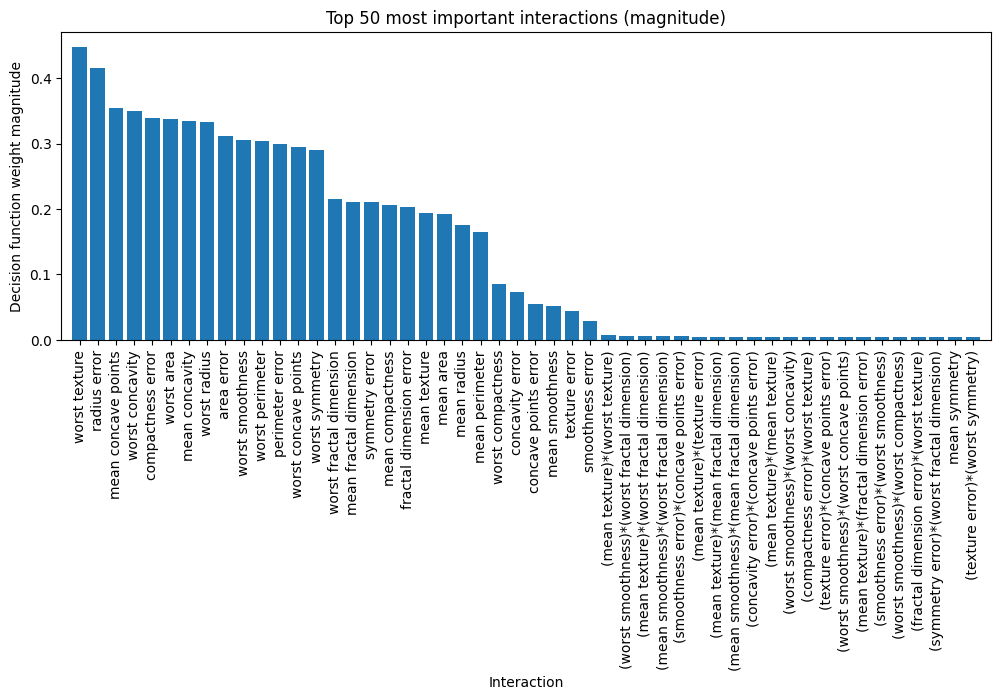

In [11]:
feat_importance_magnitude, feat_names_magnitude, sort_order = es.feature_importance(format_names=False)

# Rename ExpSVM interactions with real feature names
interaction_names_magnitude = format_interaction_names(f_name_dict, feat_names_magnitude)

# Number of features to plot
n_feat_plot = 50

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.bar(x=np.arange(n_feat_plot), height=feat_importance_magnitude[0:n_feat_plot], tick_label=interaction_names_magnitude[0:n_feat_plot])
plt.xticks(rotation=90)
plt.xlabel('Interaction')
plt.ylabel('Decision function weight magnitude')
plt.title(f'Top {n_feat_plot} most important interactions (magnitude)')
plt.xlim([-1,n_feat_plot])
if save_figs:
    plt.savefig('./images/feature_importance_wbcd.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.draw()

Plot signed importance

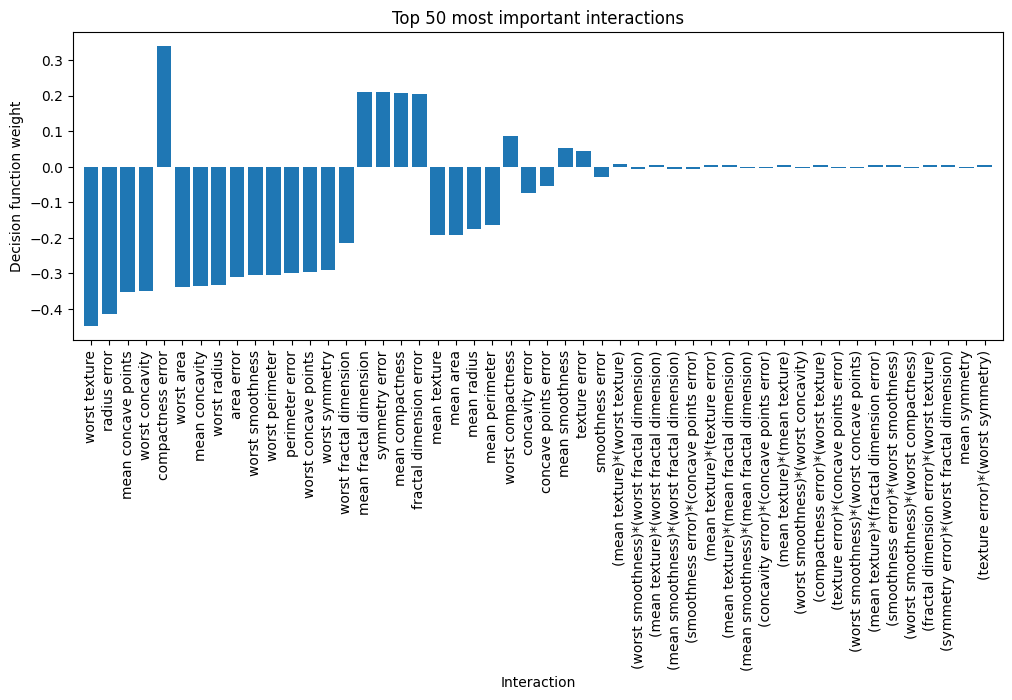

In [12]:
feat_imp_sign, _, _ = es.feature_importance(format_names=True, magnitude=False)

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.bar(x=np.arange(n_feat_plot), height=feat_imp_sign[0:n_feat_plot], tick_label=interaction_names_magnitude[0:n_feat_plot])
plt.xticks(rotation=90)
plt.xlabel('Interaction')
plt.ylabel('Decision function weight')
plt.title(f'Top {n_feat_plot} most important interactions')
plt.xlim([-1,n_feat_plot])
if save_figs:
    plt.savefig('./images/feature_importance_signed_wbcd.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.draw()

Since the feature can take both positive and negative values, we cannot directly say if the sign of the contribution to the decision function push the classification toward a positive or negative label. For this we need to know the typical values for positive and negative samples

Investigate decision function components for a single negative observation and positive observation, respectively.

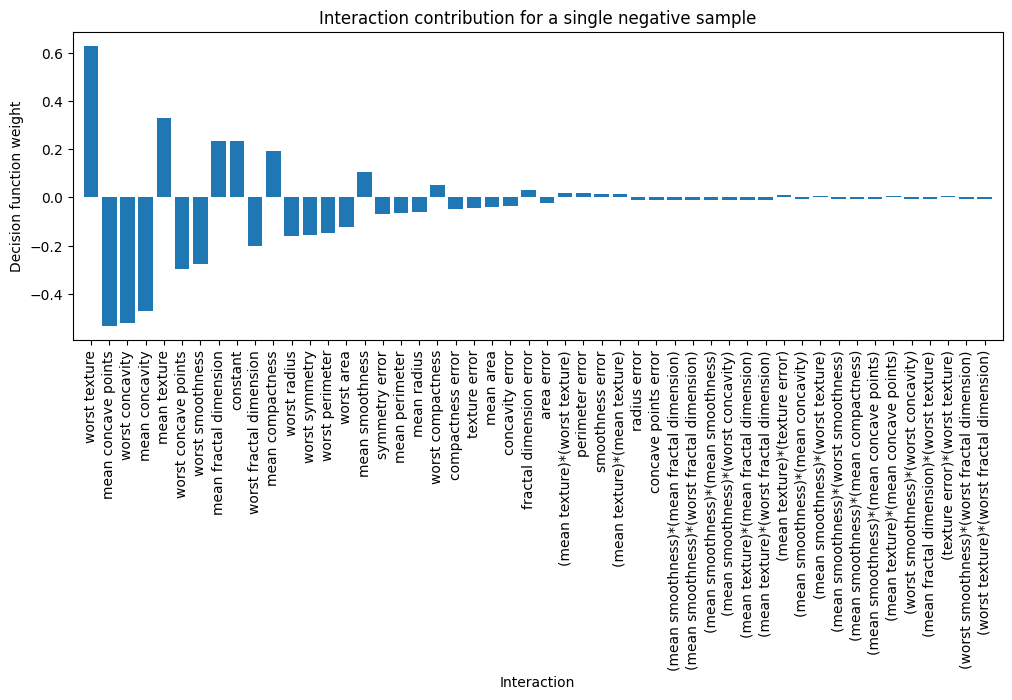

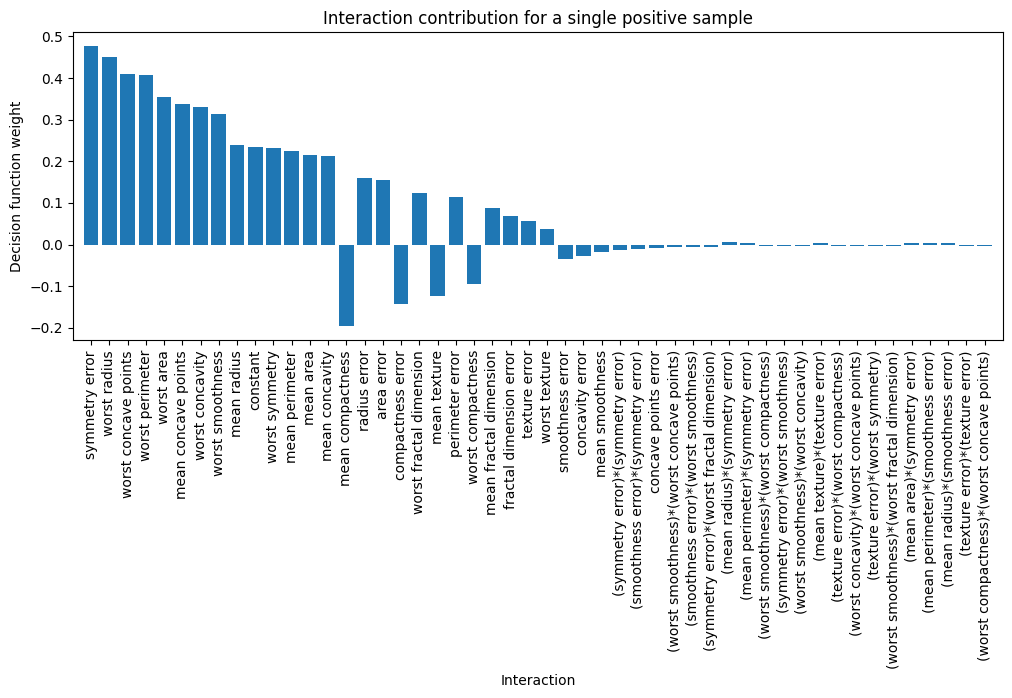

In [13]:
# Negative sample
neg_ind = np.where(y_test==-1)[0][0]
x = X_test_scale[neg_ind,:]

y_comp, feat_names = es.decision_function_components(x=x, output_interaction_names=True)
y_comp = y_comp[0]

y_comp_abs = np.abs(y_comp)

sort_order = np.flip(np.argsort(y_comp_abs))

# Rename ExpSVM interactions with real feature names
interaction_names = format_interaction_names(f_name_dict, feat_names)

# Reorder components and interaction names
y_comp_sort = y_comp[sort_order[0:n_feat_plot]]
interaction_names_sort = np.array(interaction_names)[sort_order[0:n_feat_plot]]

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.bar(x=np.arange(n_feat_plot), height=y_comp_sort, tick_label=interaction_names_sort)
plt.xticks(rotation=90)
plt.xlabel('Interaction')
plt.ylabel('Decision function weight')
plt.title('Interaction contribution for a single negative sample')
plt.xlim([-1,n_feat_plot])
if save_figs:
    plt.savefig('./images/feature_importance_single_negative_wbcd.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.draw()




# Positive sample
pos_ind = np.where(y_test==1)[0][0]
x = X_test_scale[pos_ind,:]

y_comp, feat_names = es.decision_function_components(x=x, output_interaction_names=True)
y_comp = y_comp[0]

y_comp_abs = np.abs(y_comp)

sort_order = np.flip(np.argsort(y_comp_abs))

# Rename ExpSVM interactions with real feature names
interaction_names = format_interaction_names(f_name_dict, feat_names)

# Reorder components and interaction names
y_comp_sort = y_comp[sort_order[0:n_feat_plot]]
interaction_names_sort = np.array(interaction_names)[sort_order[0:n_feat_plot]]

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.bar(x=np.arange(n_feat_plot), height=y_comp_sort, tick_label=interaction_names_sort)
plt.xticks(rotation=90)
plt.xlabel('Interaction')
plt.ylabel('Decision function weight')
plt.title('Interaction contribution for a single positive sample')
plt.xlim([-1,n_feat_plot])
if save_figs:
    plt.savefig('./images/feature_importance_single_positive_wbcd.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.draw()

Next, we calculate the contributions to the decision for each interaction for all positive and negative samples separately. The interactions are ordered in descending order from the interaction with the highest coefficient in the decision function, to the lowest. The top 35 interactions are shown.

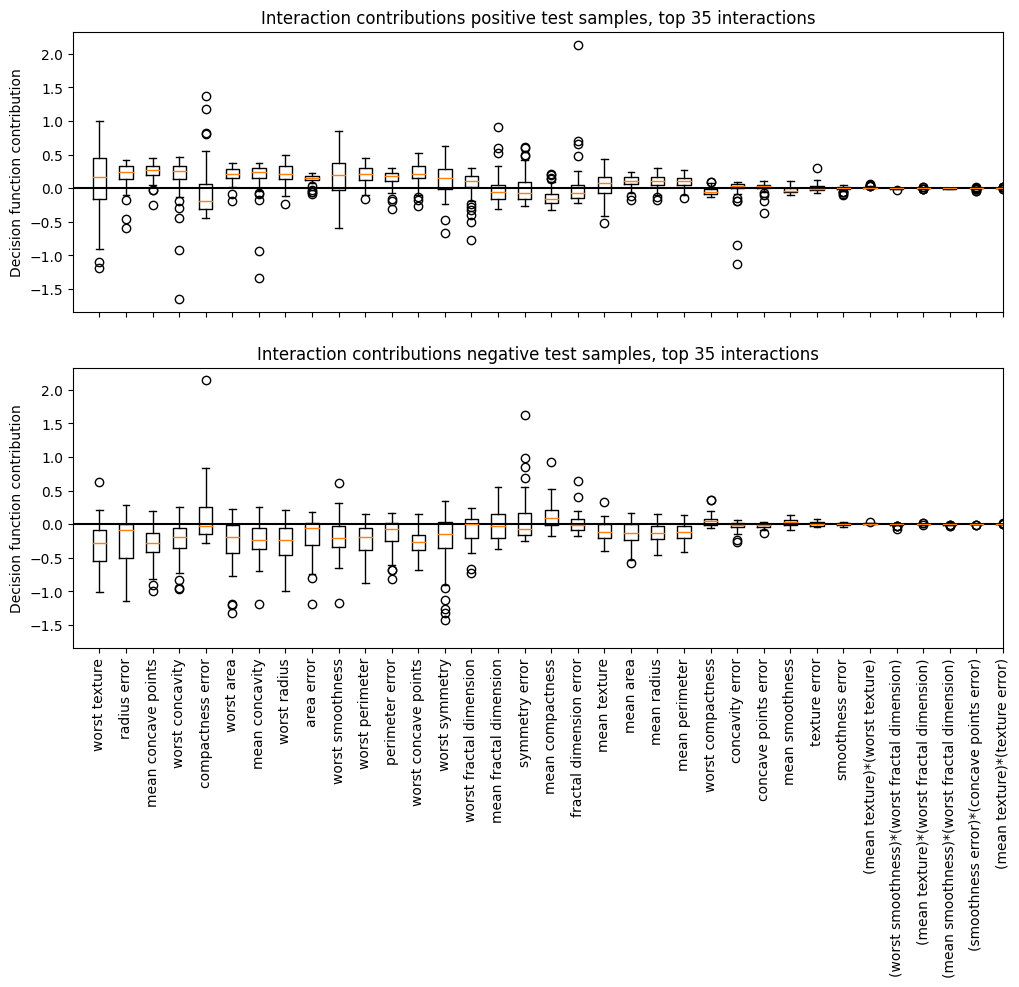

In [14]:
y_comp, feat_names = es.decision_function_components(x=X_test_scale, output_interaction_names=True)

# Drop constant from feature list
feat_names = feat_names[1:]
y_comp = y_comp[:,1:]

# Include only the top 50 interactions
n_feat_plot = 35
top_interaction_ind = np.in1d(feat_names, feat_names_magnitude[0:n_feat_plot])

y_comp = y_comp[:,top_interaction_ind]
feat_names = feat_names[top_interaction_ind]

# Sort interactions according to the magnitude in the decision function
idx1 = np.argsort(feat_names_magnitude[0:n_feat_plot])
idx2 = np.argsort(feat_names)
idx1_inv = np.argsort(idx1)
y_comp = y_comp[:, idx2][:,idx1_inv]
feat_names = feat_names[idx2][idx1_inv]

# Rename ExpSVM interactions with real feature names
interaction_names = format_interaction_names(f_name_dict, feat_names)

# Plot boxplots f the contributions to the decision functio
fig, axs = plt.subplots(2,1, figsize=(12,8), sharex=True, sharey=True)
axs[0].boxplot(x=y_comp[y_test==1,:])
axs[0].hlines(xmin=0, xmax=n_feat_plot, y=0, color='k')
axs[0].set_title('Interaction contributions positive test samples, top 35 interactions')
axs[0].set_ylabel('Decision function contribution')
axs[1].boxplot(x=y_comp[y_test==-1,:])
axs[1].hlines(xmin=0, xmax=n_feat_plot, y=0, color='k')
axs[1].set_title('Interaction contributions negative test samples, top 35 interactions')
axs[1].set_ylabel('Decision function contribution')
plt.xticks(ticks=np.arange(len(interaction_names))+1, labels=interaction_names, rotation=90)
plt.xlim([0,n_feat_plot])
if save_figs:
    plt.savefig('./images/feature_importance_boxplot_contribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Compare interaction importance from ExPSVM and Permutation Importance

We want to compare the interaction importance from ExPSVM to permutation importance, to see if the two models show similar results or different.

We want to note that permutation importance provide importance measures on the original features, not individual interactions. Therefore, the methods are not perfectly comparable. However, the SVM model we found from the crossvalidation is mainly determined from the first-order interactions, i.e. the original features themselves. The higher order interactions have a lower overall contribution to the decision. Therefore the comparison is still interesting.

This section is not complete.

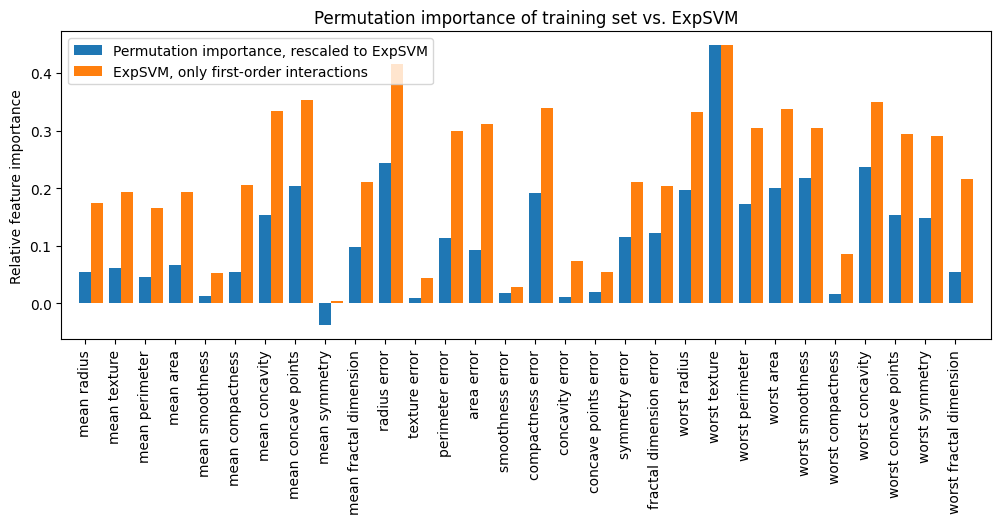

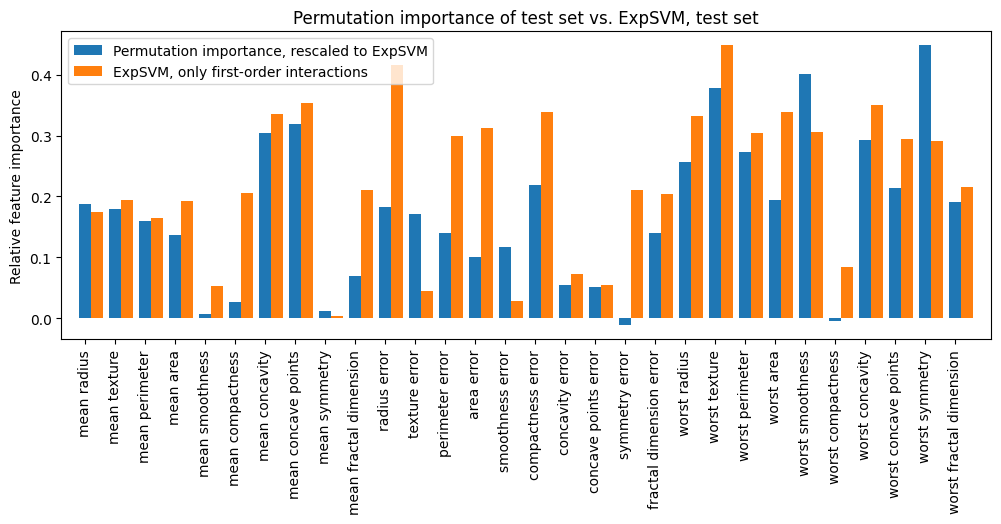

In [15]:
# Find order of features (first-order interactions) for ExPSVM
expsvm_interaction_ind = [np.where(feat_names_magnitude==f'{find}')[0][0] for find in np.arange(len(f_names))]

# Training set
r = permutation_importance(model, X_train_scale, y_train,
                           n_repeats=30,
                           random_state=0, scoring='accuracy')

# Scale permutation importance to the same values as the ExPSVM coefficients
perm_imp_mean = r['importances_mean']
perm_imp_mean_scale = feat_importance_magnitude.max()*perm_imp_mean/perm_imp_mean.max()

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.bar(x=np.arange(len(f_names))-0.2, height=perm_imp_mean_scale, tick_label=f_names, width=0.4)
ax.bar(x=np.arange(len(f_names))+0.2, height=feat_importance_magnitude[expsvm_interaction_ind], width=0.4)
plt.xticks(rotation=90)
# plt.xlabel('Interaction')
plt.ylabel('Relative feature importance')
plt.title('Permutation importance of training set vs. ExpSVM')
plt.legend(['Permutation importance, rescaled to ExpSVM', 'ExpSVM, only first-order interactions'])
plt.xlim([-1, len(f_names)])
if save_figs:
    plt.savefig('./images/permutation_importance_wbcd_train_set.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.draw()

# Test set
r = permutation_importance(model, X_test_scale, y_test,
                           n_repeats=30,
                           random_state=0, scoring='accuracy')

# Scale permutation importance to the same values as the ExPSVM coefficients
perm_imp_mean = r['importances_mean']
perm_imp_mean_scale = feat_importance_magnitude.max()*perm_imp_mean/perm_imp_mean.max()

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.bar(x=np.arange(len(f_names))-0.2, height=perm_imp_mean_scale, tick_label=f_names, width=0.4)
ax.bar(x=np.arange(len(f_names))+0.2, height=feat_importance_magnitude[expsvm_interaction_ind], width=0.4)
plt.xticks(rotation=90)
# plt.xlabel('Interaction')
plt.ylabel('Relative feature importance')
plt.title('Permutation importance of test set vs. ExpSVM, test set')
plt.legend(['Permutation importance, rescaled to ExpSVM', 'ExpSVM, only first-order interactions'])
plt.xlim([-1, len(f_names)])
if save_figs:
    plt.savefig('./images/permutation_importance_wbcd_test_set.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.draw()

For the training set, permutation importance and ExPSVM correlates quite well; large coefficients in the SVM model correspond to features that permutation importance deem more important.

For the test set, the results are more varied, particularly due to the larger number of negative importances in the permutation importance

# Compare results with SVM trained with polynomial features

Scikit-learn has the functionality to calculate polynomial features. We can preprocess the data set to get the polynomial terms, and then train a linear SVM on the polynomial features. From the linear SVM we can directly calculate the coefficients in the decision function from the support vectors.

We use the same degree as the on found from the crossvalidation, i.e. 2.

To better compare the two models, we normalize the original features to zero mean and unit variance before we calculate the polynomial features. This is the same treatment as is done when using the polynomial kernel and ExPSVM.

Test accuracy polynomial features: 0.93860 (poly. kernel accuracy: 0.98246)


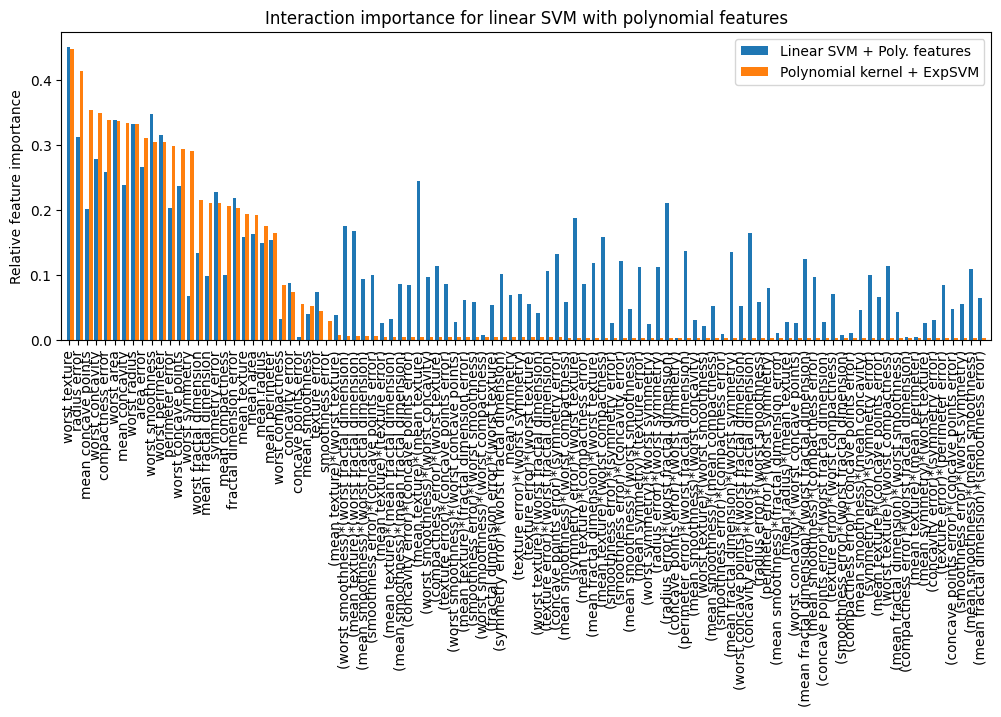

In [16]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=d_best, include_bias=False)
poly.fit(X_train_scale)

# Transform training and test set
X_train_poly = poly.transform(X_train_scale)
X_test_poly = poly.transform(X_test_scale)

# Train Linear SVM, with the same C (gamma and r are not relevant for the linear kernel)
lin_model = SVC(C=C_best, kernel='linear')

# Fit model
lin_model.fit(X_train_poly, y_train)

# Test accuracy
test_acc_poly = lin_model.score(X_test_poly, y_test)
print('Test accuracy polynomial features: {:.5f} (poly. kernel accuracy: {:.5f})'.format(test_acc_poly, test_acc))


# Create the interaction names from PolyFeatures in the same format as from ExpSVM
poly_f_names = [n.replace(' ',',').replace('x','') for n in poly.get_feature_names_out()]
# Replace powers with repeated values, e.g. replace '2^2' with '2,2'.
poly_f_names = [n if '^' not in n else ','.join([n.split('^')[0]]*int(n.split('^')[1])) for n in poly_f_names]

poly_f_names = np.array(format_interaction_names(f_name_dict, poly_f_names))

# Get coefficients from linear SVM
coef = lin_model.coef_[0]

coef_abs = np.abs(coef)

sort_order_poly = np.flip(np.argsort(coef_abs))

# Plot in order given by ExPSVM
# Number of features to plot
n_feat_plot = 100
poly_interaction_order = [np.where(poly_f_names==f'{find}')[0][0] for find in interaction_names_magnitude]
expsvm_order = [np.where(np.array(interaction_names_magnitude)==f'{find}')[0][0] for find in poly_f_names[sort_order_poly]]

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.bar(x=np.arange(n_feat_plot)-0.2, height=np.abs(coef[poly_interaction_order[0:n_feat_plot]]), tick_label=interaction_names_magnitude[0:n_feat_plot], width=0.4)
ax.bar(x=np.arange(n_feat_plot)+0.2, height=feat_importance_magnitude[0:n_feat_plot], width=0.4)
plt.xticks(rotation=90)
# plt.xlabel('Interaction')
plt.ylabel('Relative feature importance')
plt.title('Interaction importance for linear SVM with polynomial features')
plt.legend(['Linear SVM + Poly. features', 'Polynomial kernel + ExpSVM'])
plt.xlim([-1, n_feat_plot])
if save_figs:
    plt.savefig('./images/lin_svm_poly_feat_interaction_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.draw()

Results are rather inconclusive, or incomplete rather. Some features match well, while others do not at all. Higher-order features are very different between the two models. That said, the linear model is trained differently than the polynomial kernel one. Perhaps this can be the cause?